In [3]:
import numpy as np
import pandas as pd

df_tourney = pd.read_csv('DataFiles/NCAATourneyCompactResults.csv')
df_regular = pd.read_csv('DataFiles/RegularSeasonCompactResults.csv')
df_conference = pd.read_csv('DataFiles/TeamConferences.csv')

df_tourney.head()


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [4]:
df_regular.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [5]:
df_conference.head()

,Season,TeamID,ConfAbbrev
0,1985,1114,a_sun
1,1985,1147,a_sun
2,1985,1204,a_sun
3,1985,1209,a_sun
4,1985,1215,a_sun


In [6]:
df_win_team_conference = df_conference.rename(columns={'TeamID':'WTeamID', 'ConfAbbrev':'WConfAbbrev'})
df_win_team_conference.head()

,Season,WTeamID,WConfAbbrev
0,1985,1114,a_sun
1,1985,1147,a_sun
2,1985,1204,a_sun
3,1985,1209,a_sun
4,1985,1215,a_sun


In [7]:
df_loss_team_conference = df_conference.rename(columns={'TeamID':'LTeamID', 'ConfAbbrev':'LConfAbbrev'})
df_loss_team_conference.head()

,Season,LTeamID,LConfAbbrev
0,1985,1114,a_sun
1,1985,1147,a_sun
2,1985,1204,a_sun
3,1985,1209,a_sun
4,1985,1215,a_sun


In [9]:
df_regular_clean = df_regular.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], axis=1)
df_regular_clean.head()

,Season,WTeamID,LTeamID
0,1985,1228,1328
1,1985,1106,1354
2,1985,1112,1223
3,1985,1165,1432
4,1985,1192,1447


In [10]:
df = pd.merge(left=df_regular_clean, right=df_win_team_conference, how='left', on=['Season', 'WTeamID'])
df.head()

,Season,WTeamID,LTeamID,WConfAbbrev
0,1985,1228,1328,big_ten
1,1985,1106,1354,swac
2,1985,1112,1223,pac_ten
3,1985,1165,1432,ivy
4,1985,1192,1447,ecacm


In [11]:
df_regular_conference = pd.merge(left=df, right=df_loss_team_conference, how='left', on=['Season', 'LTeamID'])
df_regular_conference.head()

,Season,WTeamID,LTeamID,WConfAbbrev,LConfAbbrev
0,1985,1228,1328,big_ten,big_eight
1,1985,1106,1354,swac,meac
2,1985,1112,1223,pac_ten,a_sun
3,1985,1165,1432,ivy,ind
4,1985,1192,1447,ecacm,ecacm


In [12]:
len(df_regular_conference)

150684

In [13]:
len(df_regular_conference[df_regular_conference['WConfAbbrev'] == df_regular_conference['LConfAbbrev']])

92495

In [14]:
df_regular_conference[df_regular_conference['WConfAbbrev'] == df_regular_conference['LConfAbbrev']].head()

,Season,WTeamID,LTeamID,WConfAbbrev,LConfAbbrev
4,1985,1192,1447,ecacm,ecacm
22,1985,1173,1134,ind,ind
114,1985,1318,1436,ecacn,ecacn
176,1985,1111,1441,southern,southern
182,1985,1141,1444,mac,mac


In [16]:
df_regular_conference.groupby('WConfAbbrev').count()

,Season,WTeamID,LTeamID,LConfAbbrev
WConfAbbrev,,,,
a_sun,4133,4133,4133,4133
a_ten,6231,6231,6231,6231
aac,767,767,767,767
acc,6436,6436,6436,6436
aec,2649,2649,2649,2649
asc,399,399,399,399
awc,60,60,60,60
big_east,7270,7270,7270,7270
big_eight,1648,1648,1648,1648


In [24]:
df_regular_conference[df_regular_conference['WConfAbbrev']=='gsc']

,Season,WTeamID,LTeamID,WConfAbbrev,LConfAbbrev
73,1985,1368,1290,gsc,swac
132,1985,1368,1114,gsc,a_sun
167,1985,1402,1341,gsc,swac
237,1985,1368,1411,gsc,swac
281,1985,1368,1147,gsc,a_sun
371,1985,1322,1147,gsc,a_sun
376,1985,1402,1426,gsc,southland
465,1985,1311,1380,gsc,swac
597,1985,1368,1322,gsc,gsc
652,1985,1311,1212,gsc,swac


In [20]:
len(df_regular_conference[df_regular_conference['WConfAbbrev']=='awc'])

60

In [23]:
grouped = df_regular_conference.groupby('WConfAbbrev')
grouped.LConfAbbrev.apply(lambda x: len(x.unique()))

WConfAbbrev
a_sun         47
a_ten         49
aac           32
acc           50
aec           35
asc           33
awc           16
big_east      50
big_eight     42
big_sky       47
big_south     41
big_ten       49
big_twelve    37
big_west      45
caa           44
cusa          40
ecacm         15
ecacn         24
ecacs         14
ecc           31
gmwc          35
gsc            7
gwc           20
horizon       36
ind           49
ivy           46
maac          49
mac           48
meac          44
metro         41
mid_cont      44
mvc           49
mw_city       17
mw_coll       40
mwc           37
nac           30
nec           38
ovc           47
pac_ten       48
pac_twelve    34
patriot       39
pcaa          31
sec           50
southern      47
southland     47
summit        35
sun_belt      50
swac          44
swc           40
wac           49
wcc           50
Name: LConfAbbrev, dtype: int64

In [26]:
df_conference_tourney = pd.read_csv('DataFiles/ConferenceTourneyGames.csv')
df_conference_tourney.head()

,Season,ConfAbbrev,DayNum,WTeamID,LTeamID
0,2001,a_sun,121,1194,1144
1,2001,a_sun,121,1416,1240
2,2001,a_sun,122,1209,1194
3,2001,a_sun,122,1359,1239
4,2001,a_sun,122,1391,1273


In [27]:
df_conference_tourney[df_conference_tourney.ConfAbbrev=='ivy']

,Season,ConfAbbrev,DayNum,WTeamID,LTeamID
4406,2017,ivy,131,1343,1335
4407,2017,ivy,131,1463,1217
4408,2017,ivy,132,1343,1463


In [28]:
df_regular_clean.head()

,Season,WTeamID,LTeamID
0,1985,1228,1328
1,1985,1106,1354
2,1985,1112,1223
3,1985,1165,1432
4,1985,1192,1447


In [35]:
grouped_win = df_regular_clean.groupby(['Season', 'WTeamID'])
grouped_loss = df_regular_clean.groupby(['Season', 'LTeamID'])

In [48]:
win = grouped_win.LTeamID.count().reset_index(name='W').rename(columns={'WTeamID':'TeamID'})
win.head()
len(win)

10523

In [49]:
loss = grouped_loss.WTeamID.count().reset_index(name='L').rename(columns={'LTeamID':'TeamID'})
loss.head()
len(loss)

10534

In [57]:
df_regular_win_rate = pd.merge(left=win, right=loss, how='outer', on=['Season', 'TeamID'])
df_regular_win_rate.head()

,Season,TeamID,W,L
0,1985,1102,5.0,19.0
1,1985,1103,9.0,14.0
2,1985,1104,21.0,9.0
3,1985,1106,10.0,14.0
4,1985,1108,19.0,6.0


In [59]:
df_regular_win_rate['WRate'] = df_regular_win_rate.W / (df_regular_win_rate.W + df_regular_win_rate.L)

In [60]:
df_regular_win_rate.head()

,Season,TeamID,W,L,WRate
0,1985,1102,5.0,19.0,0.208333
1,1985,1103,9.0,14.0,0.391304
2,1985,1104,21.0,9.0,0.700000
3,1985,1106,10.0,14.0,0.416667
4,1985,1108,19.0,6.0,0.760000


In [62]:
df_tourney.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [63]:
df_tourney_clean = df_tourney.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], axis=1)
df_tourney_clean.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


In [64]:
df_WTeam_WRate = df_regular_win_rate.rename(columns={'TeamID':'WTeamID', 'WRate':'WTeamWRate'})
df_WTeam_WRate.head()

,Season,WTeamID,W,L,WTeamWRate
0,1985,1102,5.0,19.0,0.208333
1,1985,1103,9.0,14.0,0.391304
2,1985,1104,21.0,9.0,0.700000
3,1985,1106,10.0,14.0,0.416667
4,1985,1108,19.0,6.0,0.760000


In [65]:
df_LTeam_WRate = df_regular_win_rate.rename(columns={'TeamID':'LTeamID', 'WRate':'LTeamWRate'})
df_LTeam_WRate.head()

,Season,LTeamID,W,L,LTeamWRate
0,1985,1102,5.0,19.0,0.208333
1,1985,1103,9.0,14.0,0.391304
2,1985,1104,21.0,9.0,0.700000
3,1985,1106,10.0,14.0,0.416667
4,1985,1108,19.0,6.0,0.760000


In [66]:
df_WTeam_WRate.drop(labels=['W', 'L'], axis=1, inplace=True)
df_WTeam_WRate.head()

,Season,WTeamID,WTeamWRate
0,1985,1102,0.208333
1,1985,1103,0.391304
2,1985,1104,0.700000
3,1985,1106,0.416667
4,1985,1108,0.760000


In [67]:
df_LTeam_WRate.drop(labels=['W', 'L'], axis=1, inplace=True)
df_LTeam_WRate.head()

,Season,LTeamID,LTeamWRate
0,1985,1102,0.208333
1,1985,1103,0.391304
2,1985,1104,0.700000
3,1985,1106,0.416667
4,1985,1108,0.760000


In [68]:
df = pd.merge(left=df_tourney_clean, right=df_WTeam_WRate, how='left', on=['Season', 'WTeamID'])
df.head()

,Season,WTeamID,LTeamID,WTeamWRate
0,1985,1116,1234,0.636364
1,1985,1120,1345,0.620690
2,1985,1207,1250,0.925926
3,1985,1229,1425,0.740741
4,1985,1242,1325,0.766667


In [69]:
df_tourney_with_regular_win_rate = pd.merge(left=df, right=df_LTeam_WRate, how='left', on=['Season', 'LTeamID'])
df_tourney_with_regular_win_rate.head()

,Season,WTeamID,LTeamID,WTeamWRate,LTeamWRate
0,1985,1116,1234,0.636364,0.666667
1,1985,1120,1345,0.620690,0.680000
2,1985,1207,1250,0.925926,0.379310
3,1985,1229,1425,0.740741,0.678571
4,1985,1242,1325,0.766667,0.740741


In [70]:
df_tourney_with_regular_win_rate['WRateDiff'] = df_tourney_with_regular_win_rate.WTeamWRate - df_tourney_with_regular_win_rate.LTeamWRate
df_tourney_with_regular_win_rate.head()

,Season,WTeamID,LTeamID,WTeamWRate,LTeamWRate,WRateDiff
0,1985,1116,1234,0.636364,0.666667,-0.030303
1,1985,1120,1345,0.620690,0.680000,-0.059310
2,1985,1207,1250,0.925926,0.379310,0.546616
3,1985,1229,1425,0.740741,0.678571,0.062169
4,1985,1242,1325,0.766667,0.740741,0.025926


In [71]:
df_wins = pd.DataFrame()
df_wins['WRateDiff'] = df_tourney_with_regular_win_rate['WRateDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['WRateDiff'] = -df_tourney_with_regular_win_rate['WRateDiff']
df_losses['Result'] = 0

df_predictions = pd.concat([df_wins, df_losses])
df_predictions.head()

,WRateDiff,Result
0,-0.030303,1
1,-0.059310,1
2,0.546616,1
3,0.062169,1
4,0.025926,1


In [74]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

In [75]:
X_train = df_predictions.WRateDiff.values.reshape(-1,1)
y_train = df_predictions.Result.values
X_train, y_train = shuffle(X_train, y_train)

In [77]:
np.any(np.isnan(X_train))

True

In [78]:
df_predictions[np.isnan(df_predictions.WRateDiff)]

,WRateDiff,Result
406,NaN,1
424,NaN,1
429,NaN,1
435,NaN,1
438,NaN,1
1884,NaN,1
1896,NaN,1
1926,NaN,1
1953,NaN,1
1969,NaN,1


In [79]:
df = df_predictions.dropna(axis=0, how='any')
df[np.isnan(df.WRateDiff)]

,WRateDiff,Result


In [80]:
df.head()

,WRateDiff,Result
0,-0.030303,1
1,-0.059310,1
2,0.546616,1
3,0.062169,1
4,0.025926,1


In [82]:
df_predictions.dropna(axis=0, how='any', inplace=True)
X_train = df_predictions.WRateDiff.values.reshape(-1,1)
y_train = df_predictions.Result.values
X_train, y_train = shuffle(X_train, y_train)

In [83]:
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.6339, with best C: 100.0


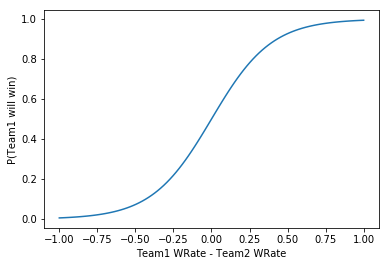

In [87]:
X = np.linspace(-1, 1, num=100).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

plt.plot(X, preds)
plt.xlabel('Team1 WRate - Team2 WRate')
plt.ylabel('P(Team1 will win)')
plt.show()